In [1]:
import jax
import jax.numpy as jnp
import jaxopt
from jax import random
from jaxopt import ScipyMinimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import partial
from jax.experimental.ode import odeint

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

In [2]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=2
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.squeeze(y_noisy)

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

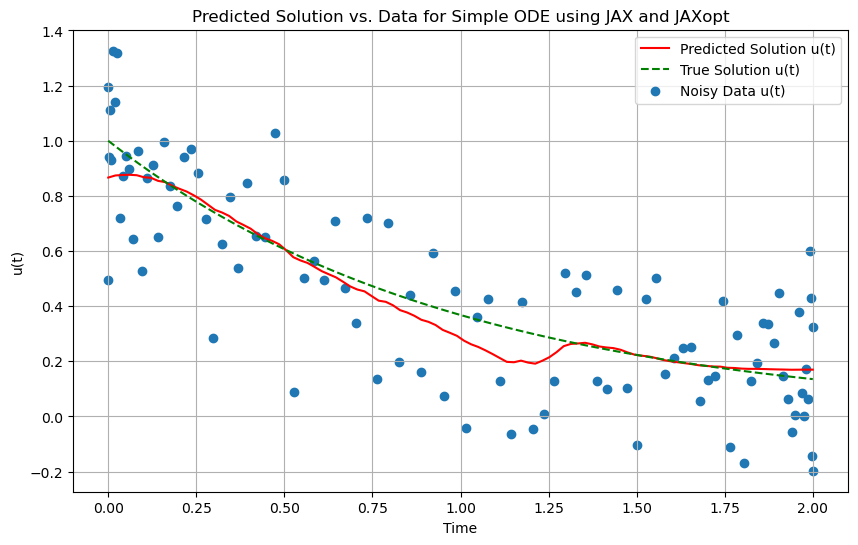

In [3]:
#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def initialize_params(rng, input_size, hidden_size, output_size):
    params = {}
    params['W1'] = random.normal(rng, (hidden_size, input_size)) * 0.1
    params['b1'] = random.normal(rng, (hidden_size,)) * 0.1
    params['W2'] = random.normal(rng, (output_size, hidden_size)) * 0.1
    params['b2'] = random.normal(rng, (output_size,)) * 0.1
    return params

def nn_output(params, t, u):
    inputs = jnp.array([t, u])
    hidden_layer = jnp.tanh(jnp.dot(params['W1'], inputs) + params['b1'])
    output = jnp.dot(params['W2'], hidden_layer) + params['b2']
    return output

#---------------------------LOSS FUNCTION DEFINITION--------------------------#
def loss_fn(params, t, y_noisy, D):
    penalty_lambda = 500

    # Predict states
    y_pred = jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i]))(jnp.arange(N)).reshape(-1)

    def collocation_residual(params, i):
        du_dt = jnp.dot(D[i], y_pred)
        nn_u = nn_output(params, t[i], y_pred[i])
        return (nn_u - du_dt)**2

    # Data fit term
    data_fit = jnp.sum((y_pred - y_noisy)**2)
    
    # Penalty term
    penalty_terms = jax.vmap(lambda i: collocation_residual(params, i))(jnp.arange(1, N))
    penalty = penalty_lambda * jnp.mean(penalty_terms)
    
    return data_fit + 0.002*penalty

#---------------------------INITIALIZE PARAMETERS--------------------------#
rng = random.PRNGKey(0)
input_size = 2
hidden_size = 10
output_size = 1
init_params = initialize_params(rng, input_size, hidden_size, output_size)

#---------------------------OPTIMIZE USING JAXOPT---------------------------#
solver = ScipyMinimize(fun=loss_fn, method="BFGS")

# Run the optimization
opt_params = solver.run(init_params, t=t, y_noisy=y_noisy, D=D).params

#---------------------------PREDICTION FUNCTION---------------------------#
def predict(params, t):
    return jax.vmap(lambda i: nn_output(params, t[i], y_noisy[i]))(jnp.arange(len(t))).reshape(-1)

# Generate predictions using optimized parameters
y_pred = predict(opt_params, t)

#---------------------------INTERPOLATION---------------------------#
interp_fn = interp1d(t, y_pred, kind='cubic', fill_value='extrapolate')
x_new = jnp.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS---------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using JAX and JAXopt')
plt.grid(True)
plt.show()

---

In [181]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 300
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.squeeze(y_noisy)

#---------------------------------------COLLOCATION MATRIX--------------------------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

In [185]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [190]:
type(estimated_solution[1])

jaxlib.xla_extension.ArrayImpl

In [195]:
class ODEOptimizationModelJaxopt:
    def __init__(self, y_observed, t, D, layer_sizes, penalty_lambda=2, smoothing_lambda=100, max_iter=1000, act_func="tanh", w_init_method="random"):
        self.y_observed = y_observed
        self.t = t
        self.D = D
        self.penalty_lambda = penalty_lambda
        self.smoothing_lambda = smoothing_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes

    def initialize_params(self, u_init, v_init):
        params = {}
        input_size = self.layer_sizes[0]
        for i in range(len(self.layer_sizes) - 1):
            output_size = self.layer_sizes[i + 1]
            params[f'W{i}'] = self.initialize_weights(rng, (output_size, input_size))
            params[f'b{i}'] = self.initialize_biases(rng, output_size)
            input_size = output_size
        # Initialize u and v as variables to be optimized
        params['u'] = u_init
        params['v'] = v_init
        return params

    def initialize_weights(self, rng, shape):
        if self.w_init_method == 'random':
            return random.normal(rng, shape) * 0.1
        elif self.w_init_method == 'xavier':
            return random.normal(rng, shape) * jnp.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return random.normal(rng, shape) * jnp.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, rng, size):
        return random.normal(rng, (size,)) * 0.1

    def nn_output(self, params, t, u, v):
        inputs = jnp.array([t, u, v])
        for i in range(len(self.layer_sizes) - 1):
            W = params[f'W{i}']
            b = params[f'b{i}']
            inputs = jnp.dot(W, inputs) + b
            if i < len(self.layer_sizes) - 2:
                if self.act_func == "tanh":
                    inputs = jnp.tanh(inputs)
                elif self.act_func == "sigmoid":
                    inputs = 1 / (1 + jnp.exp(-inputs))
                elif self.act_func == "softplus":
                    inputs = jax.nn.softplus(inputs)
        return inputs

    def loss_fn(self, params, t, y_observed, D):
        def collocation_residual(params, i):
            du_dt = jnp.dot(D[i], params['u'])
            dv_dt = jnp.dot(D[i], params['v'])
            nn_u, nn_v = self.nn_output(params, t[i], params['u'][i], params['v'][i])
            return ((nn_u - du_dt)**2 + (nn_v - dv_dt)**2) / 2

        u_pred = params['u']
        v_pred = params['v']

        # model.u, model.v - y_observed
        data_fit = jnp.sum((jnp.stack((u_pred, v_pred), axis=-1) - y_observed)**2)
        penalty_terms = jax.vmap(lambda i: collocation_residual(params, i))(jnp.arange(1, len(t)))
        penalty = jnp.mean(penalty_terms)

        second_derivative = jnp.sum(jnp.diff(jnp.stack((u_pred, v_pred), axis=-1), n=2, axis=0)**2, axis=0)
        smoothing_term = jnp.sum(second_derivative)

        return data_fit + self.penalty_lambda * penalty + self.smoothing_lambda * smoothing_term

    def optimize_model(self, params):
        solver = ScipyMinimize(fun=self.loss_fn, method="BFGS", maxiter=self.max_iter)
        opt_result = solver.run(params, t=self.t, y_observed=self.y_observed, D=self.D)
        # Return optimized parameters and loss value
        return opt_result.params, opt_result.state.fun_val

    def predict(self, params, t, initial_conditions):
        def model(state, t):
            u, v = state
            nn_u, nn_v = self.nn_output(params, t, u, v)
            return nn_u, nn_v

        states = odeint(model, initial_conditions, t)
        u_pred, v_pred = states[:, 0], states[:, 1]
        return u_pred, v_pred
    
    def extract_uv_params(self, params):
        return params['u'], params['v']

# Example usage
layer_sizes = [3, 40, 2]
penalty_lambda = 100
smoothing_lambda = 20
max_iter = 1000

# Initialize model
model = ODEOptimizationModelJaxopt(y_noisy, t, D, layer_sizes, penalty_lambda=penalty_lambda, smoothing_lambda=smoothing_lambda, max_iter=max_iter)

# Initialize random parameters
rng = random.PRNGKey(0)
init_params = model.initialize_params(estimated_solution[0], estimated_solution[1])

# Optimize model
best_params, best_value = model.optimize_model(init_params)

print(f"Best loss value: {best_value}")

# Generate predictions using optimized parameters and initial conditions
initial_conditions = jnp.array([0.0, 1.0])
u_pred, v_pred = model.predict(best_params, t, initial_conditions)

u_opt, v_opt = model.extract_uv_params(best_params)

In [59]:
# OPTIMIAZTION WITH A VALIDATION SET

class ODEOptimizationModelJaxopt:
    def __init__(self, y_observed, t, D, layer_sizes, penalty_lambda=2, smoothing_lambda=100, max_iter=1000, act_func="tanh", w_init_method="random"):
        self.y_observed = y_observed
        self.t = t
        self.D = D
        self.penalty_lambda = penalty_lambda
        self.smoothing_lambda = smoothing_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        # Split data into training and validation sets
        self.train_split = int(0.8 * len(t))
        self.t_train, self.t_val = t[:self.train_split], t[self.train_split:]
        self.y_train, self.y_val = y_observed[:self.train_split], y_observed[self.train_split:]
        self.D_train, self.D_val = D[:self.train_split, :self.train_split], D[self.train_split:, self.train_split:]

    def initialize_params(self, rng):
        params = {}
        input_size = self.layer_sizes[0]
        for i in range(len(self.layer_sizes) - 1):
            output_size = self.layer_sizes[i + 1]
            params[f'W{i}'] = self.initialize_weights(rng, (output_size, input_size))
            params[f'b{i}'] = self.initialize_biases(rng, output_size)
            input_size = output_size
        return params

    def initialize_weights(self, rng, shape):
        if self.w_init_method == 'random':
            return random.normal(rng, shape) * 0.1
        elif self.w_init_method == 'xavier':
            return random.normal(rng, shape) * jnp.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return random.normal(rng, shape) * jnp.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, rng, size):
        return random.normal(rng, (size,)) * 0.1

    def nn_output(self, params, t, u, v):
        inputs = jnp.array([t, u, v])
        for i in range(len(self.layer_sizes) - 1):
            W = params[f'W{i}']
            b = params[f'b{i}']
            inputs = jnp.dot(W, inputs) + b
            if i < len(self.layer_sizes) - 2:
                if self.act_func == "tanh":
                    inputs = jnp.tanh(inputs)
                elif self.act_func == "sigmoid":
                    inputs = 1 / (1 + jnp.exp(-inputs))
                elif self.act_func == "softplus":
                    inputs = jax.nn.softplus(inputs)
        return inputs

    def loss_fn(self, params, t, y_observed, D):
        def collocation_residual(params, i):
            du_dt = jnp.dot(D[i], y_pred[:, 0])
            dv_dt = jnp.dot(D[i], y_pred[:, 1])
            nn_u, nn_v = self.nn_output(params, t[i], y_pred[i, 0], y_pred[i, 1])
            return ((nn_u - du_dt)**2 + (nn_v - dv_dt)**2) / 2

        y_pred = jax.vmap(lambda i: self.nn_output(params, t[i], y_observed[i, 0], y_observed[i, 1]))(jnp.arange(len(t)))

        data_fit = jnp.sum((y_pred - y_observed)**2)
        penalty_terms = jax.vmap(lambda i: collocation_residual(params, i))(jnp.arange(1, len(t)))
        penalty = jnp.mean(penalty_terms)

        second_derivative = jnp.sum(jnp.diff(y_pred, n=2, axis=0)**2, axis=0)
        smoothing_term = jnp.sum(second_derivative)

        return data_fit + self.penalty_lambda * penalty + self.smoothing_lambda * smoothing_term

    def optimize_model(self, params, t, y_observed, D):
        solver = ScipyMinimize(fun=self.loss_fn, method="BFGS", maxiter=self.max_iter)
        opt_result = solver.run(params, t=t, y_observed=y_observed, D=D)
        return opt_result.params, opt_result.state.fun_val  # Correct attribute to access the loss value

    def predict(self, params, t):
        return jax.vmap(lambda i: self.nn_output(params, t[i], self.y_observed[i, 0], self.y_observed[i, 1]))(jnp.arange(len(t)))

    def find_optimal_lambdas(self, penalty_lambda_range, smoothing_lambda_range):
        best_value = float('inf')
        best_penalty_lambda = None
        best_smoothing_lambda = None
        best_params = None

        rng = random.PRNGKey(0)
        init_params = self.initialize_params(rng)

        for penalty_lambda in penalty_lambda_range:
            for smoothing_lambda in smoothing_lambda_range:
                self.penalty_lambda = penalty_lambda
                self.smoothing_lambda = smoothing_lambda

                # Optimize on training set
                opt_params, _ = self.optimize_model(init_params, self.t_train, self.y_train, self.D_train)

                # Evaluate on validation set
                val_loss = self.loss_fn(opt_params, self.t_val, self.y_val, self.D_val)

                if val_loss < best_value:
                    best_value = val_loss
                    best_penalty_lambda = penalty_lambda
                    best_smoothing_lambda = smoothing_lambda
                    best_params = opt_params

        self.penalty_lambda = best_penalty_lambda
        self.smoothing_lambda = best_smoothing_lambda
        return best_penalty_lambda, best_smoothing_lambda, best_value, best_params

# parameters
layer_sizes = [3, 30, 2]
penalty_lambda_range = jnp.linspace(0.1, 10, 10)
smoothing_lambda_range = jnp.linspace(1, 100, 10)
max_iter = 1000


model = ODEOptimizationModelJaxopt(y_noisy, t, D, layer_sizes, max_iter=max_iter)
best_penalty_lambda, best_smoothing_lambda, best_value, best_params = model.find_optimal_lambdas(penalty_lambda_range, smoothing_lambda_range)

print(f"Optimal penalty_lambda: {best_penalty_lambda}")
print(f"Optimal smoothing_lambda: {best_smoothing_lambda}")
print(f"Best validation loss value: {best_value}")

# generate predictions using optimized parameters
y_pred = model.predict(best_params, t)

Optimal penalty_lambda: 0.1
Optimal smoothing_lambda: 66.99999999999999
Best validation loss value: 13.32476314647378


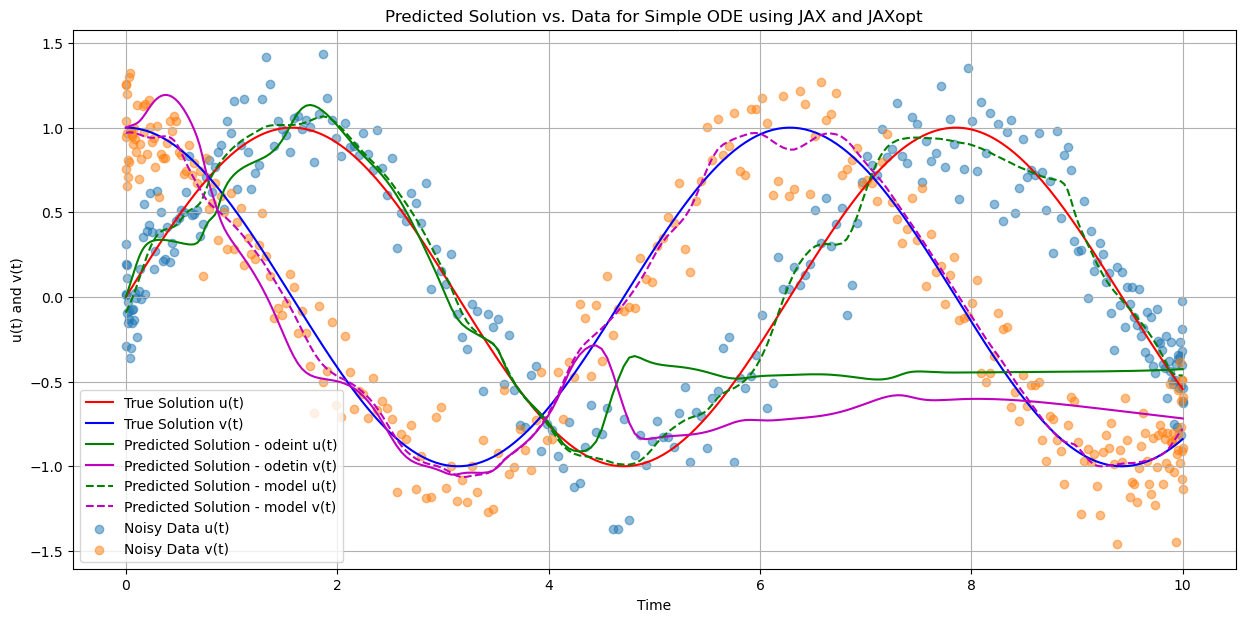

In [194]:
plt.figure(figsize=(15, 7))
plt.plot(t, y[:, 0], 'r', label='True Solution u(t)')
plt.plot(t, y[:, 1], 'b', label='True Solution v(t)')
plt.plot(t, u_pred, 'g', label='Predicted Solution - odeint u(t)')
plt.plot(t, v_pred, 'm', label='Predicted Solution - odetin v(t)')
plt.plot(t, u_opt, 'g--', label='Predicted Solution - model u(t)')
plt.plot(t, v_opt, 'm--', label='Predicted Solution - model v(t)')
plt.scatter(t, y_noisy[:, 0], label='Noisy Data u(t)', alpha=0.5)
plt.scatter(t, y_noisy[:, 1], label='Noisy Data v(t)', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('u(t) and v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using JAX and JAXopt')
plt.grid(True)
plt.show()


## Predictions

In [174]:
"""#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)"""

#-----------------------------------------------------------------------------------------------------#

end_time = 20
t_new, y_new, _, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, "chebyshev", initial_state)
u_pred, v_pred  = model.predict(best_params, t_new, initial_conditions)

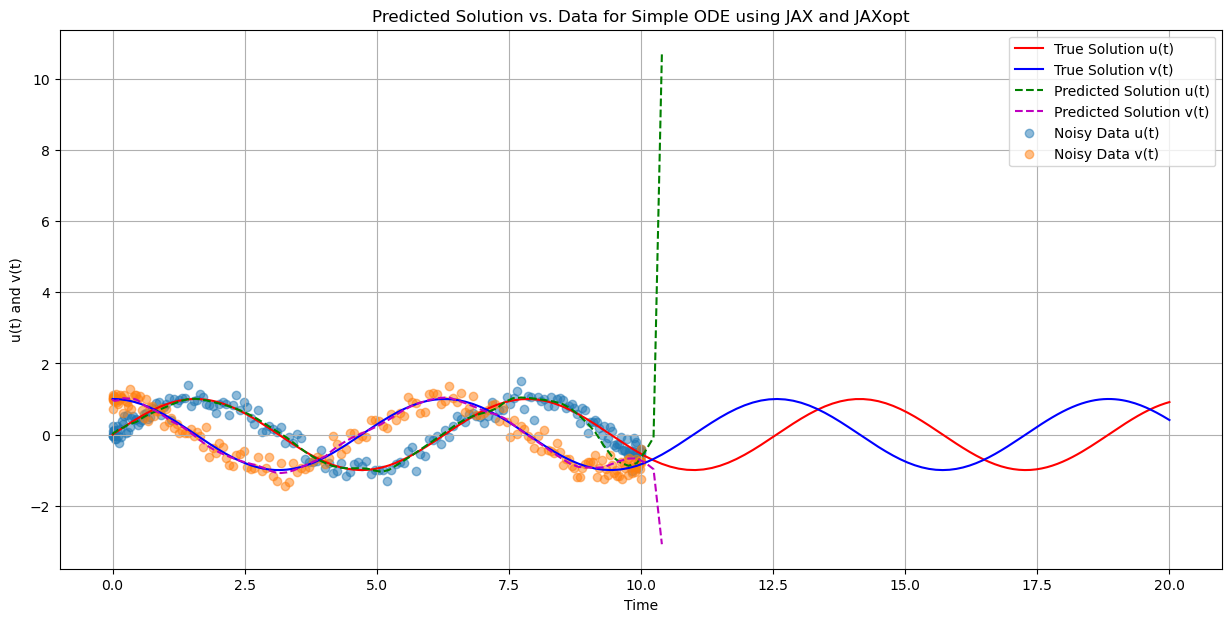

In [180]:
t2 = 103

plt.figure(figsize=(15, 7))
plt.plot(t_new, y_new[:, 0], 'r', label='True Solution u(t)')
plt.plot(t_new, y_new[:, 1], 'b', label='True Solution v(t)')
plt.plot(t_new[:t2], u_pred[:t2], 'g--', label='Predicted Solution u(t)')
plt.plot(t_new[:t2], v_pred[:t2], 'm--', label='Predicted Solution v(t)')
plt.scatter(t, y_noisy[:, 0], label='Noisy Data u(t)', alpha=0.5)
plt.scatter(t, y_noisy[:, 1], label='Noisy Data v(t)', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('u(t) and v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using JAX and JAXopt')
plt.grid(True)
plt.show()


## KKT (Karush–Kuhn–Tucker)

#### KKT System

The Karush-Kuhn-Tucker (KKT) conditions are necessary conditions for a solution in nonlinear programming to be optimal, given certain regularity conditions. These conditions include:

1. **Primal feasibility**: The original constraints must be satisfied (the original problem's constraints)
2. **Dual feasibility**: The Lagrange multipliers associated with the inequality constraints must be non-negative.
3. **Stationarity**: The gradient of the Lagrangian with respect to the primal variables must be zero at the optimal point.
    * At the optimal point, the weighted sum of the gradients of the objective and the constraints should be zero.
    * ∇L = 0
4. **Complementary slackness**: The product of each Lagrange multiplier and its corresponding constraint must be zero.
    * if it is strictly less than zero, the corresponding multiplier must be zero; 
    * if the constraint is exactly zero, the multiplier can be positive.



The KKT system residuals for our problem are computed as follows:

$$
\text{KKT Residuals} = \nabla_{\text{params}} \mathcal{L}(\text{params}, \lambda, \mu, t, y_{\text{observed}}, D)
$$

Where:
- $ \nabla_{\text{params}} \mathcal{L}(\text{params}, \lambda, \mu, t, y_{\text{observed}}, D) $ is the gradient of the Lagrangian with respect to the primal variables (params).

For our specific problem, we define the KKT system as:

$$
\text{grad\_lagr} = \nabla_{\text{params}} \mathcal{L}(\text{params}, \lambda, \mu, t, y_{\text{observed}}, D)
$$

The constraints are:

$$
\text{g1} = y_{\text{pred}[:, 0]} - 1
$$

$$
\text{g2} = -y_{\text{pred}[:, 1]} + 2
$$

$$
\text{h1} = y_{\text{pred}[:, 0]} + y_{\text{pred}[:, 1]} - 3
$$

Finally, the KKT residuals are:

$$
\text{KKT Residuals} = \text{concatenate}([\text{grad\_lagr}, \lambda \cdot \text{array}([\text{g1}, \text{g2}]), \nu \cdot \text{array}([\text{h1}])])
$$

This ensures that the solution meets the optimality criteria by minimizing the KKT residuals.


In [56]:
def kkt_system(self, params_and_duals):
    params, lambdas, nus = params_and_duals[:-3], params_and_duals[-3:-1], params_and_duals[-1:]
    grad_lagr = jax.grad(self.lagrangian, argnums=0)(params, lambdas, nus, self.t, self.y_observed, self.D)
    y_pred = jax.vmap(lambda i: self.nn_output(params, self.t[i], self.y_observed[i, 0], self.y_observed[i, 1]))(jnp.arange(len(self.t)))
    g1 = y_pred[:, 0] - 1
    g2 = -y_pred[:, 1] + 2
    h1 = y_pred[:, 0] + y_pred[:, 1] - 3
    kkt_residuals = jnp.concatenate([grad_lagr, lambdas * jnp.array([g1, g2]), nus * jnp.array([h1])])
    return kkt_residuals

#### Lagrangian Function

The Lagrangian function combines the objective function, the ODE constraints, and their associated penalty terms. It is used to transform a constrained optimization problem into an unconstrained one, making it easier to solve using numerical methods.

The Lagrangian for our optimization problem is given by:

$$
\mathcal{L}(\text{params}, \lambda, \mu, t, y_{\text{observed}}, D) = \text{DataFit} + \lambda \cdot \text{PenaltyTerm} + \mu \cdot \text{SmoothingTerm}
$$

Where:
- **Data Fitting Term**: 

$$
\text{DataFit} = \sum_{i=0}^{N-1} (y_{\text{pred}, i} - y_{\text{observed}, i})^2
$$

This term measures the difference between the predicted values $ y_{\text{pred}} $ and the observed values $ y_{\text{observed}} $. Minimizing this term ensures that the model fits the observed data well.

- **Penalty Term Enforcing the ODE Constraints**: 

$$
\text{PenaltyTerm} = \sum_{i=1}^{N-1} \left( \frac{1}{2} \left( \frac{d y_{\text{pred}, i, 0}}{dt} - \text{nn}_u \right)^2 + \frac{1}{2} \left( \frac{d y_{\text{pred}, i, 1}}{dt} - \text{nn}_v \right)^2 \right)
$$

This term penalizes deviations from the ODE constraints. The predicted values $ y_{\text{pred}} $ should satisfy the ODEs, where $ \text{nn}_u $ and $ \text{nn}_v $ are the neural network outputs for $ u $ and $ v $ respectively.

- **Smoothing Term Enforcing Smoothness**:

$$
\text{SmoothingTerm} = \sum_{i=0}^{N-3} \left( \frac{d^2 y_{\text{pred}, i}}{dt^2} \right)^2
$$

This term enforces smoothness in the predicted solution by penalizing the second derivative of $ y_{\text{pred}} $. Minimizing this term helps in obtaining a smooth solution.

Putting it all together, the Lagrangian is:

$$
\mathcal{L}(\text{params}, \lambda, \mu, t, y_{\text{observed}}, D) = \sum_{i=0}^{N-1} (y_{\text{pred}, i} - y_{\text{observed}})^2 + \lambda \sum_{i=1}^{N-1} \left( \frac{1}{2} \left( \frac{d y_{\text{pred}, i, 0}}{dt} - \text{nn}_u \right)^2 + \frac{1}{2} \left( \frac{d y_{\text{pred}, i, 1}}{dt} - \text{nn}_v \right)^2 \right) + \mu \sum_{i=0}^{N-3} \left( \frac{d^2 y_{\text{pred}, i}}{dt^2} \right)^2
$$


In [ ]:
def nn_output(self, params, t, u, v):
    inputs = jnp.array([t, u, v])
    idx = 0
    for i in range(len(self.layer_sizes) - 1):
        W = params[idx]
        b = params[idx + 1]
        inputs = jnp.dot(W, inputs) + b
        if i < len(self.layer_sizes) - 2:
            if self.act_func == "tanh":
                inputs = jnp.tanh(inputs)
            elif self.act_func == "sigmoid":
                inputs = 1 / (1 + jnp.exp(-inputs))
            elif self.act_func == "softplus":
                inputs = jax.nn.softplus(inputs)
        idx += 2
    return inputs

In [57]:
def lagrangian(self, params, lambdas, nus, t, y_observed, D):
    """
    Compute the Lagrangian, including the objective function, penalty terms, and smoothing term.
    
    Arguments:
    - params: Neural network parameters.
    - lambdas: Lagrange multipliers for the inequality constraints.
    - nus: Lagrange multipliers for the equality constraints.
    - t: Time points.
    - y_observed: Observed data.
    - D: Derivative matrix.
    
    Returns:
    - lagrangian_value: The value of the Lagrangian function.
    """
    
    # vectorized prediction for each time point using the neural network
    y_pred = jax.vmap(lambda i: self.nn_output(params, t[i], y_observed[i, 0], y_observed[i, 1]))(jnp.arange(len(t)))
    # jnp.arange(len(t)) generates an array from 0 to len(t) - 1
    # jax.vmap applies the function to each element of the array
    
    # compute the data fitting term (sum of squared differences between predicted and observed values)
    data_fit = jnp.sum((y_pred - y_observed) ** 2)
    
    # vectorized computation of collocation residuals for each time point (except the first one)
    penalty_terms = jax.vmap(lambda i: self.collocation_residual(params, t, y_pred, D, i))(jnp.arange(1, len(t)))
    penalty = jnp.mean(penalty_terms)
    
    # second derivative of the predicted values to enforce smoothness
    second_derivative = jnp.sum(jnp.diff(y_pred, n=2, axis=0) ** 2, axis=0)
    smoothing_term = jnp.sum(second_derivative)
    
    # the Lagrangian value by combining the data fitting term, penalty term, and smoothing term
    lagrangian_value = data_fit + self.penalty_lambda * penalty + 100 * smoothing_term
    
    return lagrangian_value


In [60]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
from jaxopt import ScipyMinimize
from jax import tree_util

class ODEOptimizationModelJaxopt:
    def __init__(self, y_observed, t, D, layer_sizes, penalty_lambda=2, max_iter=1000, act_func="tanh", w_init_method="random"):
        self.y_observed = y_observed
        self.t = t
        self.D = D
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes

    def initialize_params(self, rng):
        params = []
        input_size = self.layer_sizes[0]
        for i in range(len(self.layer_sizes) - 1):
            output_size = self.layer_sizes[i + 1]
            params.append(self.initialize_weights(rng, (output_size, input_size)))
            params.append(self.initialize_biases(rng, output_size))
            input_size = output_size
        return params

    def initialize_weights(self, rng, shape):
        if self.w_init_method == 'random':
            return random.normal(rng, shape) * 0.1
        elif self.w_init_method == 'xavier':
            return random.normal(rng, shape) * jnp.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return random.normal(rng, shape) * jnp.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, rng, size):
        return random.normal(rng, (size,)) * 0.1

    def nn_output(self, params, t, u, v):
        inputs = jnp.array([t, u, v])
        idx = 0
        for i in range(len(self.layer_sizes) - 1):
            W = params[idx]
            b = params[idx]
            inputs = jnp.dot(W, inputs) + b
            if i < len(self.layer_sizes) - 2:
                if self.act_func == "tanh":
                    inputs = jnp.tanh(inputs)
                elif self.act_func == "sigmoid":
                    inputs = 1 / (1 + jnp.exp(-inputs))
                elif self.act_func == "softplus":
                    inputs = jax.nn.softplus(inputs)
            idx += 2
        return inputs

    def lagrangian(self, params, lambdas, nus, t, y_observed, D):
        y_pred = jax.vmap(lambda i: self.nn_output(params, t[i], y_observed[i, 0], y_observed[i, 1]))(jnp.arange(len(t)))
        data_fit = jnp.sum((y_pred - y_observed) ** 2)

        # Constraints
        g1 = y_pred[:, 0] - 1
        g2 = -y_pred[:, 1] + 2
        h1 = y_pred[:, 0] + y_pred[:, 1] - 3

        penalty_terms = jax.vmap(lambda i: self.collocation_residual(params, t, y_pred, D, i))(jnp.arange(1, len(t)))
        penalty = jnp.mean(penalty_terms)

        second_derivative = jnp.sum(jnp.diff(y_pred, n=2, axis=0) ** 2, axis=0)
        smoothing_term = jnp.sum(second_derivative)

        lagrangian_value = data_fit + self.penalty_lambda * penalty + 100 * smoothing_term
        lagrangian_value += jnp.sum(lambdas[0] * g1) + jnp.sum(lambdas[1] * g2) + jnp.sum(nus[0] * h1)
        return lagrangian_value

    def collocation_residual(self, params, t, y_pred, D, i):
        du_dt = jnp.dot(D[i], y_pred[:, 0])
        dv_dt = jnp.dot(D[i], y_pred[:, 1])
        nn_u, nn_v = self.nn_output(params, t[i], y_pred[i, 0], y_pred[i, 1])
        return ((nn_u - du_dt) ** 2 + (nn_v - dv_dt) ** 2) / 2

    def kkt_system(self, params_and_duals):
        params, lambdas, nus = params_and_duals[:-3], params_and_duals[-3:-1], params_and_duals[-1:]
        grad_lagr = jax.grad(self.lagrangian, argnums=0)(params, lambdas, nus, self.t, self.y_observed, self.D)
        y_pred = jax.vmap(lambda i: self.nn_output(params, self.t[i], self.y_observed[i, 0], self.y_observed[i, 1]))(jnp.arange(len(self.t)))
        g1 = y_pred[:, 0] - 1
        g2 = -y_pred[:, 1] + 2
        h1 = y_pred[:, 0] + y_pred[:, 1] - 3
        kkt_residuals = jnp.concatenate([grad_lagr, lambdas * jnp.array([g1, g2]), nus * jnp.array([h1])])
        return kkt_residuals

    def optimize_model(self):
        rng = random.PRNGKey(0)
        init_params = self.initialize_params(rng)
        flat_params = [jnp.ravel(p) for p in init_params]
        flat_params_array = jnp.concatenate(flat_params)
        init_dual_params = jnp.array([1.0, 1.0, 1.0])  # Initial guesses for lambdas and nus
        init_params_and_duals = jnp.concatenate([flat_params_array, init_dual_params])

        solver = ScipyMinimize(fun=lambda params_and_duals: jnp.sum(self.kkt_system(params_and_duals) ** 2), method="BFGS", maxiter=self.max_iter)
        opt_params_and_duals = solver.run(init_params_and_duals).params
        return opt_params_and_duals

    def predict(self, params_and_duals, t):
        flat_params = params_and_duals[:-3]
        param_shapes = [p.shape for p in self.initialize_params(random.PRNGKey(0))]
        params = []
        start = 0
        for shape in param_shapes:
            size = np.prod(shape)
            params.append(flat_params[start:start + size].reshape(shape))
            start += size
        return jax.vmap(lambda i: self.nn_output(params, t[i], self.y_observed[i, 0], self.y_observed[i, 1]))(jnp.arange(len(t)))

# Initialize and optimize the model
model = ODEOptimizationModelJaxopt(y_noisy, t, D, layer_sizes=[3, 20, 2])
opt_params_and_duals = model.optimize_model()

# Generate predictions using optimized parameters
y_pred = model.predict(opt_params_and_duals, t)


TypeError: sub got incompatible shapes for broadcasting: (200, 3), (200, 2).